In [1]:
import sys
import os
# Add the parent directory to the path to import MVPAnalyzer
sys.path.append(os.path.dirname(os.getcwd()))

from MVPAnalyzer import Analyzer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mvpa = Analyzer('/home/maxw/Documents/ESSTECH25/MVP300_DATA/Stationary_Profiling/',subdirs=True)

# mvpa.help()

mvpa.load_mvp_data(format='ncdf') 

mvpa.load_ctd_data(format='ncdf',data_path_ctd='/home/maxw/Documents/ESSTECH25/BATHYSONDE/DATA/TRAIT/NCDF/')

mvpa.keep_selected_profiles([0, 10, 8, 2], [0, 2, 4, 8])
# mvpa.keep_selected_profiles([0,10,8,2])


mvpa.compute_waterflow(0)

mvpa.viscous_heating_correction()
print('Viscous heating correction done.')
mvpa.filtering_surface_waves()
print('Surface wave filtering done.')
mvpa.temporal_lag_correction(correction=True)
print('Temporal lag correction done.')

/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/seabird/cnv.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Found 1 MVP files in the directory: /home/maxw/Documents/ESSTECH25/MVP300_DATA/Stationary_Profiling/
MVP data loaded successfully.
Found 5 CTD files in the directory: /home/maxw/Documents/ESSTECH25/BATHYSONDE/DATA/TRAIT/NCDF/
CTD data loaded successfully.
Water flow speed computed successfully.
Viscous heating correction done.
Surface wave filtering done.
Temporal lag correction done.


In [5]:
# Import PyTorch and neural network components
try:
    import torch

    print("PyTorch imported successfully!")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    # Import our custom neural network
    from utils import prepare_training_data
    from architecture import ThermalMassDataset
    from train import train_thermal_mass_network
    print("Neural network architecture imported successfully!")
    
except ImportError as e:
    print(f"Error importing PyTorch: {e}")
    print("Please install PyTorch: pip install torch")
    print("Continuing with data preparation...")

PyTorch imported successfully!
PyTorch version: 2.8.0
CUDA available: True
Neural network architecture imported successfully!


In [6]:


# Prepare the training data
mvp_data, ctd_data = prepare_training_data(mvpa)

Processing 8 profiles...
Added pair (0,1) - Down: 22354 pts, Up: 28877 pts
Added pair (2,3) - Down: 20131 pts, Up: 20208 pts
Added pair (4,5) - Down: 20271 pts, Up: 20326 pts
Added pair (6,7) - Down: 20163 pts, Up: 20185 pts

Prepared 4 valid profile pairs for training


In [ ]:
import train
import importlib
importlib.reload(train)
from train import train_thermal_mass_network

# Train the model if we have data and PyTorch is available
if 'torch' in globals() and len(mvp_data['TEMP_down']) > 0:
    print("Starting neural network training...")
    trained_model, train_losses, val_losses = train_thermal_mass_network(mvp_data, ctd_data, 
                                                                        sequence_length=800, 
                                                                        num_epochs=20)
    
    if trained_model is not None:
        print("Training completed successfully!")
    else:
        print("Training failed.")
else:
    print("Skipping training: PyTorch not available or no data")

Starting neural network training...
Training neural network with 4 profile pairs...
Training set: 3 pairs, Validation set: 1 pairs
Using device: cuda
Model parameters: 48,520
Error during training: list index out of range


/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Traceback (most recent call last):
  File "/home/maxw/Documents/ESSTECH25/MVP_simple_routine/neural_th/train.py", line 63, in train_thermal_mass_network
    for batch_idx, batch in enumerate(train_loader):
  File "/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 734, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 790, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/maxw/miniconda3/envs/oceanapp/lib/python3.11/site-packages/torch/

TypeError: cannot unpack non-iterable NoneType object

\n============================================================
TRAINING ANALYSIS


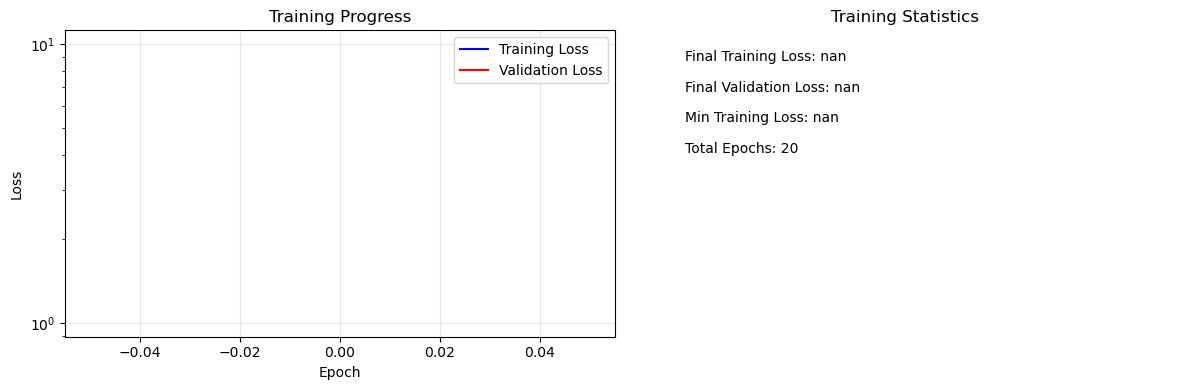

\nPredicted parameters for profile pair 0:
alpha0_down : nan
alphaS_down : nan
tau0_down   : nan
tauS_down   : nan
alpha0_up   : nan
alphaS_up   : nan
tau0_up     : nan
tauS_up     : nan


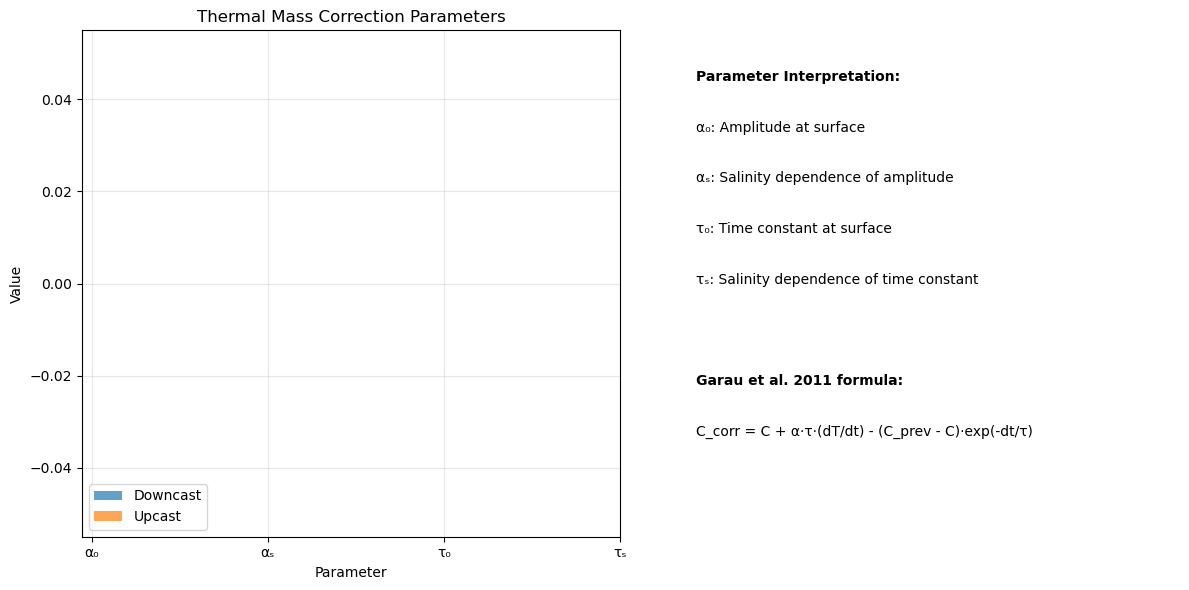

In [7]:
# Analyze training results and test the trained model
def analyze_training_results(train_losses, val_losses=None):
    """Plot training curves and analyze results"""
    if train_losses is None:
        print("No training results to analyze")
        return
    
    plt.figure(figsize=(12, 4))
    
    # Training curves
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    if val_losses is not None:
        plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Loss statistics
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f"Final Training Loss: {train_losses[-1]:.6f}", transform=plt.gca().transAxes)
    if val_losses is not None:
        plt.text(0.1, 0.8, f"Final Validation Loss: {val_losses[-1]:.6f}", transform=plt.gca().transAxes)
    plt.text(0.1, 0.7, f"Min Training Loss: {min(train_losses):.6f}", transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f"Total Epochs: {len(train_losses)}", transform=plt.gca().transAxes)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Training Statistics')
    
    plt.tight_layout()
    plt.show()

def test_model_predictions(model, mvp_data, ctd_data, test_idx=0):
    """Test the model on a specific profile pair"""
    if model is None:
        print("No trained model available")
        return
    
    if test_idx >= len(mvp_data['TEMP_down']):
        print(f"Test index {test_idx} not available")
        return
    
    try:
        device = next(model.parameters()).device
        
        # Prepare test data
        dataset = ThermalMassDataset(mvp_data, ctd_data, sequence_length=800)
        test_sample = dataset[test_idx]
        
        # Add batch dimension
        input_features = test_sample['input_features'].unsqueeze(0).to(device)
        
        # Get model predictions
        model.eval()
        with torch.no_grad():
            predicted_params = model(input_features)
        
        # Extract parameters
        params = predicted_params[0].cpu().numpy()
        param_names = ['alpha0_down', 'alphaS_down', 'tau0_down', 'tauS_down',
                       'alpha0_up', 'alphaS_up', 'tau0_up', 'tauS_up']
        
        print(f"\\nPredicted parameters for profile pair {test_idx}:")
        print("=" * 50)
        for name, value in zip(param_names, params):
            print(f"{name:12s}: {value:.6f}")
        
        # Visualize parameters
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        down_params = params[:4]
        up_params = params[4:]
        x = np.arange(4)
        width = 0.35
        
        plt.bar(x - width/2, down_params, width, label='Downcast', alpha=0.7)
        plt.bar(x + width/2, up_params, width, label='Upcast', alpha=0.7)
        plt.xlabel('Parameter')
        plt.ylabel('Value')
        plt.title('Thermal Mass Correction Parameters')
        plt.xticks(x, ['α₀', 'αₛ', 'τ₀', 'τₛ'])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Parameter interpretation
        plt.subplot(1, 2, 2)
        plt.text(0.1, 0.9, "Parameter Interpretation:", transform=plt.gca().transAxes, fontweight='bold')
        plt.text(0.1, 0.8, f"α₀: Amplitude at surface", transform=plt.gca().transAxes)
        plt.text(0.1, 0.7, f"αₛ: Salinity dependence of amplitude", transform=plt.gca().transAxes)
        plt.text(0.1, 0.6, f"τ₀: Time constant at surface", transform=plt.gca().transAxes)
        plt.text(0.1, 0.5, f"τₛ: Salinity dependence of time constant", transform=plt.gca().transAxes)
        plt.text(0.1, 0.3, "Garau et al. 2011 formula:", transform=plt.gca().transAxes, fontweight='bold')
        plt.text(0.1, 0.2, "C_corr = C + α·τ·(dT/dt) - (C_prev - C)·exp(-dt/τ)", transform=plt.gca().transAxes, fontsize=10)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return params
        
    except Exception as e:
        print(f"Error testing model: {e}")
        import traceback
        traceback.print_exc()
        return None

# Analyze results if training was successful
if 'trained_model' in locals() and trained_model is not None:
    print("\\n" + "="*60)
    print("TRAINING ANALYSIS")
    print("="*60)
    
    analyze_training_results(train_losses, val_losses if 'val_losses' in locals() else None)
    
    # Test model on first profile
    if len(mvp_data['TEMP_down']) > 0:
        predicted_params = test_model_predictions(trained_model, mvp_data, ctd_data, test_idx=0)
else:
    print("No trained model to analyze")